In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.registrationdata as regdata
import defmod.hamiltonian_multishape as hamiltonian
from defmod.energyfunctional import EnergyFunctional_unconstrained, EnergyFunctional
from defmod import optimize


torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
data = regdata.Nuts()
data()
source = data.source
target = data.target
module_list = data.modules
reduce_background = False

sigma_bg = 0.005
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg, reduce_background=False)

constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

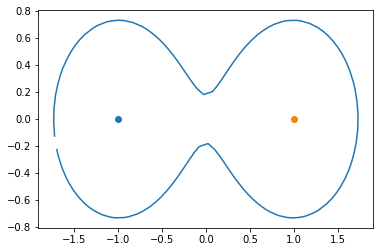

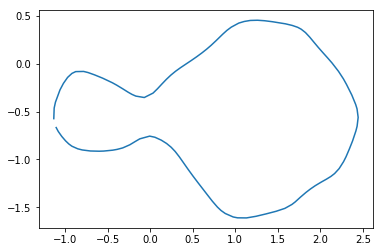

In [3]:
pts_source = source[0].detach().numpy()
pts_target = target[0].detach().numpy()
gd0 = modules.module_list[0].manifold[1].gd.view(-1,2)
gd1 = modules.module_list[0].manifold[2].gd.view(-1,2)


plt.figure()
plt.plot(pts_source[:,0], pts_source[:,1])
plt.scatter(gd0.detach().numpy()[:,0],gd0.detach().numpy()[:,1])
plt.scatter(gd1.detach().numpy()[:,0],gd1.detach().numpy()[:,1])

plt.figure()
plt.plot(pts_target[:,0], pts_target[:,1])
plt.show()


In [4]:
mod = modules.module_list[0]
h = dm.hamiltonian.Hamiltonian(mod)
def attach(modules, target):
    return dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[0].manifold.gd.view(-1,2) for i in range(len(target))], target)
E = EnergyFunctional_unconstrained(mod, h, source, target, dim=2, gamma=0.01, attach=attach)

In [5]:
gd0_tensor = torch.cat(h.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(h.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
X = [gd0_tensor, mom0_tensor]

from defmod import optimize
X[1] = optimize.BFGS(E, X, disp=True)(maxiter=100)

cost: [ 0.] attach: 12.933211334882209
cost: [ 0.] attach: 12.933211334882209
cost: [ 0.12911621] attach: 23.816974304916418
cost: [ 0.12911621] attach: 23.816974304916418
cost: [ 0.01218481] attach: 6.880685810897216
cost: [ 0.01218481] attach: 6.880685810897216
cost: [ 0.36388727] attach: 37.99509036013241
cost: [ 0.36388727] attach: 37.99509036013241
cost: [ 0.01596049] attach: 6.019198563833392
cost: [ 0.01596049] attach: 6.019198563833392
cost: [ 0.01835241] attach: 6.510598938886133
cost: [ 0.01835241] attach: 6.510598938886133
cost: [ 0.01625506] attach: 5.993999715236749
cost: [ 0.01625506] attach: 5.993999715236749
cost: [ 0.01545189] attach: 5.988316233053046
cost: [ 0.01545189] attach: 5.988316233053046
cost: [ 0.01474261] attach: 5.987492210560481
cost: [ 0.01474261] attach: 5.987492210560481
cost: [ 0.01456535] attach: 5.9875403090225925
cost: [ 0.01456535] attach: 5.9875403090225925
cost: [ 0.01432124] attach: 5.987591403321495
cost: [ 0.01432124] attach: 5.98759140332149

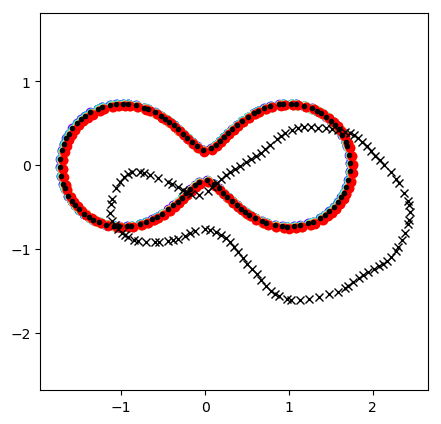

In [10]:
h.module.manifold.fill_gd(X[0])
h.module.manifold.fill_cotan(X[1])

states, controls = dm.shooting.shoot_euler(H, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

figsize=(5,5)

fig_shooting = plt.figure(figsize = figsize, dpi=100)
for s,c in zip(states, colors):
    plt.scatter(s[0][0].gd.view(-1,2)[:, 0].detach().numpy(), s[0][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[1][0].gd.view(-1,2)[:, 0].detach().numpy(), s[1][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
#plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
#plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

In [7]:
gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
X = [gd0_tensor, mom0_tensor]

def attach(modules, target):
    return dm.attachement.VarifoldAttachement([1, 0.2])([modules.module_list[i].module_list[0].manifold.gd.view(-1,2) for i in range(len(target))], target)

E = EnergyFunctional(H.module, H, constr_Id, source, target, dim=2, gamma=1., attach=attach)

In [8]:
X[1] = optimize.BFGS(E, X, disp=True)(maxiter=20)

cost: [ 0.05774412] attach: 5.966743099326638
cost: [ 0.05774412] attach: 5.966743099326638
cost: [ 0.91156533] attach: 4.672911037485281
cost: [ 0.91156533] attach: 4.672911037485281
cost: [ 0.85693559] attach: 4.776502604549165
cost: [ 0.85693559] attach: 4.776502604549165
cost: [ 0.81714424] attach: 4.659252612229473
cost: [ 0.81714424] attach: 4.659252612229473
cost: [ 0.46682739] attach: 4.989781450215859
cost: [ 0.46682739] attach: 4.989781450215859
cost: [ 0.50350816] attach: 4.944724006220018
cost: [ 0.50350816] attach: 4.944724006220018
cost: [ 0.57767413] attach: 4.869273939551842
cost: [ 0.57767413] attach: 4.869273939551842
cost: [ 0.54147314] attach: 4.9049308096956405
cost: [ 0.54147314] attach: 4.9049308096956405
Optimization terminated successfully.
         Current function value: 5.446404
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8


In [23]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
        return H()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd().copy()).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan().copy()).requires_grad_().view(-1)


test_gradcheck_Hamiltonian()

True